# Interpolazione Nearest-Neighbor

In Python l'interpolazione nearest neighbor è presente nella libreria $\verb|scipy.interpolate|$.

## Kodak Dataset

Le immagini utilizzate sono state prese dal dataset di immagini RAW Kodak (.PCD):

> https://www.math.purdue.edu/~lucier/PHOTO_CD/

In [1]:
# Loading Kodak Image Dataset

import numpy as np
import pandas
import imageio.v2 as imageio
import matplotlib.pyplot as plt

data_images = pandas.read_csv('dataset.csv')
image_list = []

for i in range(data_images.shape[0]):
    pcd_images = imageio.imread(data_images.loc[i, 'image_path'], format = 'PCD')
    image_list.append(pcd_images)

# Errori nella lettura: FILE [3], [8], [9], [16], [17], [18]

In [2]:
import numpy as np
from scipy.interpolate import griddata

def nearest_interpolation(A, m, n):
    
    grid_x, grid_y = np.meshgrid(np.linspace(0, m-1, m), np.linspace(0, n-1, n), indexing = 'ij')

    n, m = A.shape
    A = A.flatten()

    nan_indices = np.isnan(A) 
    known_indices = ~nan_indices
    known_list = np.flatnonzero(known_indices)

    kr, kc = np.unravel_index(known_list, (n, m))

    points = np.zeros([len(kr),2])
    points[:,0] = kr
    points[:,1] = kc 

    A = np.reshape(A, [n,m])
    values = A[kr,kc] 

    return griddata(points, values, (grid_x, grid_y), method = 'nearest') 

## Demosaicizzazione tramite Interpolazione Nearest-Neighbor sul Pattern di Bayer

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr


def demosaicing_bayer(image, Red_Inpaint, Green_Inpaint, Blue_Inpaint):
    
    bayer_color = np.empty((image.shape), float)
    bayer_color[:] = np.nan
    bayer_color[0::2, 0::2, 0] = Red_Inpaint[0::2, 0::2]   # top left
    bayer_color[0::2, 1::2, 1] = Green_Inpaint[0::2, 1::2] # top right
    bayer_color[1::2, 0::2, 1] = Green_Inpaint[1::2, 0::2] # bottom left
    bayer_color[1::2, 1::2, 2] = Blue_Inpaint[1::2, 1::2]  # bottom right
    
    Gnearest = bayer_color.copy().astype(float)
    
    tic = time.perf_counter()
    
    for i in range(3):
        Gnearest[:, :, i] = nearest_interpolation(bayer_color[:, :, i], bayer_color.shape[0], bayer_color.shape[1])
        
    toc_nearest = time.perf_counter()
    
    nearest_process_time = toc_nearest - tic

    print('Tempo impiegato per l\'Interpolazione Nearest Neighbor in secondi:', nearest_process_time)

    mse_original = mse(image, image)
    ssim_original = ssim(image, image, data_range = image.max() - image.min(), channel_axis=2)
    psnr_original = psnr(image, image)

    mse_nearest = mse(image, Gnearest)
    ssim_nearest = ssim(image, Gnearest, data_range = Gnearest.max() - Gnearest.min(), channel_axis=2)
    psnr_nearest = psnr(image, Gnearest)

#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4), sharex=True, sharey=True)
#     ax = axes.ravel()

#     ax[0].imshow(image.astype(np.uint8))
#     ax[0].set_xlabel('MSE: ' + str(round(mse_original, 2)) + '\n' + 'SSIM: ' + str(round(ssim_original, 2)) + 
#                      '\n' + 'PSNR: ' + str(round(psnr_original, 2)) )
#     ax[0].set_title('Original Image')  

#     ax[3].imshow(Gnearest.astype(np.uint8))
#     ax[3].set_xlabel('MSE:' + str(round(mse_nearest, 2)) + '\n' + 'SSIM: ' + str(round(ssim_nearest, 2)) + 
#                      '\n' + 'PSNR: ' + str(round(psnr_nearest, 2)))
#     ax[3].set_title('Nearest-Neighbor Interpolation')
    
    plt.imshow(Gnearest.astype(np.uint8))
    plt.xlabel('MSE:' + str(round(mse_nearest, 2)) + '\n' + 'SSIM: ' + str(round(ssim_nearest, 2)) + 
                     '\n' + 'PSNR: ' + str(round(psnr_nearest, 2)))
    plt.title('Nearest-Neighbor Interpolation')
    
    return nearest_process_time, mse_nearest, ssim_nearest, psnr_nearest

In [5]:
# Bayer Pattern RGGB
def bayer_pattern(image):

    m,n = image[:,:,0].shape # Considero le nuove dimensioni

    Red_Inpaint = np.nan *np.ones(image[:,:,0].shape)
    Red_Inpaint[0:m-1:2, 0:n-1:2] = image[0:m-1:2, 0:n-1:2, 0]

    Green_Inpaint = np.nan *np.ones(image[:,:,1].shape)
    Green_Inpaint[0:m:2, 1:n:2] = image[0:m:2, 1:n:2, 1]
    Green_Inpaint[1:m:2, 0:n-1:2] = image[1:m:2, 0:n-1:2, 1]

    Blue_Inpaint = np.nan *np.ones(image[:,:,2].shape)
    Blue_Inpaint[1:m:2, 1:n:2] = image[1:m:2, 1:n:2, 2]
    
    nearest_process_time, mse_nearest, ssim_nearest, psnr_nearest = demosaicing_bayer(image, Red_Inpaint, Green_Inpaint, Blue_Inpaint)
    
    return nearest_process_time, mse_nearest, ssim_nearest, psnr_nearest

## Riduzione del rumore mediante Interpolazione Nearest-Neighbor

In [4]:
def denoising_function(image):
    
    m, n = image[:,:,0].shape
    
    G = image.astype(float) 
    G[np.random.rand(*G.shape) < 0.50] = np.nan 

    Gnearest = G.copy()
    
    tic = time.perf_counter()
    
    for i in range(3):
        Gnearest[:, :, i] = nearest_interpolation(G[:, :, i], m, n)
        
    toc_nearest = time.perf_counter()
    
    nearest_process_time = toc_nearest - tic

    print('Tempo impiegato per l\'Interpolazione Nearest Neighbor in secondi:', nearest_process_time)
    
    Gnearest = Gnearest.astype(np.uint8)

    mse_original = mse(image, image)
    ssim_original = ssim(image, image, data_range = image.max() - image.min(), channel_axis=2)
    psnr_original = psnr(image, image)

    mse_nearest = mse(image, Gnearest)
    ssim_nearest = ssim(image, Gnearest, data_range = Gnearest.max() - Gnearest.min(), channel_axis=2)
    psnr_nearest = psnr(image, Gnearest)

#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4), sharex=True, sharey=True)
#     ax = axes.ravel()

#     ax[0].imshow(image.astype(np.uint8))
#     ax[0].set_xlabel('MSE: ' + str(round(mse_original, 2)) + '\n' + 'SSIM: ' + str(round(ssim_original, 2)) + 
#                      '\n' + 'PSNR: ' + str(round(psnr_original, 2)) )
#     ax[0].set_title('Original Image')
    
#     ax[1].imshow(Glinear.astype(np.uint8))
#     ax[1].set_xlabel('MSE:' + str(round(mse_linear, 2)) + '\n' + 'SSIM: ' + str(round(ssim_linear, 2)) + 
#                      '\n' + 'PSNR: ' + str(round(psnr_linear, 2)))
#     ax[1].set_title('Linear Interpolation')
    
    plt.imshow(Gnearest.astype(np.uint8))
    plt.xlabel('MSE:' + str(round(mse_nearest, 2)) + '\n' + 'SSIM: ' + str(round(ssim_nearest, 2)) + 
                     '\n' + 'PSNR: ' + str(round(psnr_nearest, 2)))
    plt.title('Denoising Nearest-Neighbor')
    
    return nearest_process_time, mse_nearest, ssim_nearest, psnr_nearest

## Test e salvataggio dei risultati

In [6]:
import pandas as pd
import os

def save_results(i, nearest_process_time, mse_nearest, ssim_nearest, psnr_nearest, folder_path):

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    csv_path = os.path.join(folder_path, 'results_nearest.csv')

    data = {
        'Image': [i+1],
        'Time Elapsed': [nearest_process_time],
        'MSE': [mse_nearest],
        'SSIM': [ssim_nearest],
        'PSNR': [psnr_nearest]
    }

    results = pd.DataFrame(data)

    if os.path.exists(csv_path):
        results.to_csv(csv_path, mode = 'a', header = False, index = False)
    else:
        results.to_csv(csv_path, mode = 'w', header = True, index = False)
        
    plt.savefig(folder_path + '/nearest_' + str(i+1) + '.png')

Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2.2907354


C:\Users\Psi\anaconda3\lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2.2849086000000014
Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2.3242209999999996
Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2.2785940999999994
Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2.2551156999999975
Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2.2986758000000016
Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2.2823059000000008
Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2.255095999999998
Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2.2679881000000037
Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2.2569355999999985
Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2.270399900000001
Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2.2626437999999993
Tempo impiegato per l'Interpolazione Nearest Neighbor in secondi: 2

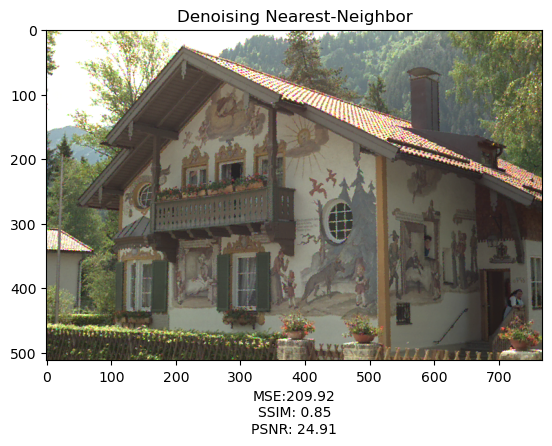

In [7]:
for i in range(len(image_list)):
    if(i in [3, 8, 9, 16, 17, 18]):
        continue
    folder_path = 'results/denoising/nearest'
    nearest_process_time, mse_nearest, ssim_nearest, psnr_nearest = denoising_function(image_list[i])
    save_results(i, nearest_process_time, mse_nearest, ssim_nearest, psnr_nearest, folder_path)

In [8]:
import pandas as pd

df = pd.read_csv('results/denoising/nearest/results_nearest.csv')

# Assuming the columns with decimals are known, for example, 'column1' and 'column2'
# Convert these columns to strings, then back to floats to fix truncation
df['Time Elapsed'] = df['Time Elapsed'].astype(float)
df['MSE'] = df['MSE'].astype(float)
df['SSIM'] = df['SSIM'].astype(float)
df['PSNR'] = df['PSNR'].astype(float)

# Optionally, round to a specific number of decimal places
df['Time Elapsed'] = df['Time Elapsed'].round(2)
df['MSE'] = df['MSE'].round(2)
df['SSIM'] = df['SSIM'].round(2)
df['PSNR'] = df['PSNR'].round(2)

# Save the corrected DataFrame to a new CSV file
df.to_csv('results/denoising/nearest/results_nearest_trunc.csv', index=False)
